In [52]:
import pandas as pd
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import defaultdict

In [3]:
# Define USCB API key & variables of interest
apikey_USCB = 'b83c9e8cbf71b387db3681c39e0d7ef719f6344f'
variables_USCB = ['B19013_001E','B19301_001E','B23025_005E','B23025_003E','B19083_001E','B01003_001E','B01002_001E','B05002_013E','B25077_001E']

In [112]:
# def acs_extractor(api_key, year, variables, state_code=None):
#     '''
#     Extract state-level acs data
#     '''
#     # Define API Base URL for ACS 1-Year Estimates (from https://api.census.gov/data.html)
#     base_url = 'https://api.census.gov/data/{}/acs/acs1'.format(year)
#     variables_str = ','.join(variables)
    
#     # Define query params based on input
#     if state_code is not None:
#         params = {
#             'get': variables_str,
#             'for': f'state:{state_code}',
#             'key': api_key
#         }
#     else:
#         params = {
#             'get': variables_str,
#             'for': f'state:*',
#             'key': api_key
#         }

#     # Make API request
#     response = requests.get(base_url, params=params)
#     # Store data into df if extraction is succesful
#     if response.status_code == 200:
#         data = response.json()
#         # print(type(data)) #<class 'list'>; return data shows nested list
#         df = pd.DataFrame(data[1:], columns=data[0])
#     else:
#         print(f"Error for year {year}: {response.status_code}")
#         df = None

#     return df

In [113]:
def acs_extractor(api_key, year, variables, state_code=None, session=None):
    '''
    Extract state-level ACS data using a session (if provided).
    '''
    # Define API Base URL for ACS 1-Year Estimates
    base_url = f'https://api.census.gov/data/{year}/acs/acs1'
    variables_str = ','.join(variables)
    
    # Define query params based on input
    if state_code is not None:
        params = {
            'get': variables_str,
            'for': f'state:{state_code}',
            'key': api_key
        }
    else:
        params = {
            'get': variables_str,
            'for': 'state:*',
            'key': api_key
        }

    # Use session if provided, otherwise create a new session
    if session is None:
        with requests.Session() as session:
            response = session.get(base_url, params=params)
    else:
        response = session.get(base_url, params=params)

    # Store data into df if extraction is successful
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data[1:], columns=data[0])
    else:
        print(f"Error for year {year}: {response.status_code}")
        df = None

    return df


In [114]:
# # Pull ACS data for 2017-2023
years = [2017,2018,2019, 2020, 2021,2022,2023]
acs_data = []

# for year in years:
#     df = acs_extractor(apikey_USCB,year,variables=variables_USCB,state_code=None)
#     if df is not None:
#         df['Year'] = year
#         acs_data.append(df)
# acs_data = pd.concat(acs_data)
# # acs_data.to_pickle('assets/acs_data.pkl')
# acs_data.to_csv('assets/acs_data.csv', index=False)

# acs_data = pd.read_pickle('assets/acs_data.pkl')
acs_data = pd.read_csv('assets/acs_data.csv')
acs_data.head()

,B19013_001E,B19301_001E,B23025_005E,B23025_003E,B19083_001E,B01003_001E,B01002_001E,B05002_013E,B25077_001E,state,Year
0,43529,23121,92744,1319719,0.4790,2984100,37.5,65718,120200,28,2017
1,53578,29438,141163,3061464,0.4618,6113532,38.5,257102,156700,29,2017
2,53386,29428,18844,538121,0.4539,1050493,40.0,23109,231300,30,2017
3,59970,30915,34967,1043919,0.4391,1920076,36.5,143331,155800,31,2017
4,58003,30166,90032,1514888,0.4606,2998039,38.0,596019,258200,32,2017


In [115]:
acs_data.columns

Index(['B19013_001E', 'B19301_001E', 'B23025_005E', 'B23025_003E',
       'B19083_001E', 'B01003_001E', 'B01002_001E', 'B05002_013E',
       'B25077_001E', 'state', 'Year'],
      dtype='object')

In [116]:
# # Next, match state code and also the column names 
# # - Find union of variables for all the want years

# # Initialize an empty set to store the union of variables across years
# union_of_variables = set()
# var_descr_mapper = defaultdict(dict) #maps variable to description 
# with requests.Session() as session:
#     for year in years:
#     # Step 1: Fetch the variable descriptions (what each variable code means)
#         url_variables = f"https://api.census.gov/data/{year}/acs/acs1/variables.json"
#         response = requests.get(url_variables)
#         if response.status_code == 200:
#             # Parse the JSON response
#             acs_variables = response.json()
            
#             # Extract the variable codes (the dictionary keys)
#             variable_codes = set(acs_variables['variables'].keys())
            
#             # Take the union of the variables across years
#             union_of_variables = union_of_variables.union(variable_codes)

#             # Extract description in 'label' and 'concept' from new set of variable codes
#             for variable_code in variable_codes:
#                 keys = acs_variables['variables'][variable_code].keys()
#                 label = acs_variables['variables'][variable_code].get('label', '')
#                 concept = acs_variables['variables'][variable_code].get('concept', '')

#                 var_descr_mapper[variable_code] = f'{label} {concept}'

#             print(f"Processed variables for {year}")
#         else:
#             print(f"Failed to fetch variables for {year}. Status code: {response.status_code}")

# # Convert the union of variables to a list and create a DataFrame
# union_of_variables_df = pd.DataFrame(list(union_of_variables), columns=['Variable_Code'])
# union_of_variables_df['Description'] = union_of_variables_df['Variable_Code'].map(var_descr_mapper)#.fillna('No Description Available')
# union_of_variables_df['Description'] = union_of_variables_df['Description'].str.replace(r'!!',' ', regex=True)
# # Optionally, save this union of variables to a CSV file
# union_of_variables_df.to_csv('assets/union_of_variables_2017_2023.csv', index=False)
union_of_variables_df = pd.read_csv('assets/union_of_variables_2017_2023.csv')
# Display the first few rows of the DataFrame
union_of_variables_df.head()

,Variable_Code,Description
0,B19037I_036E,Estimate Total: Householder 45 to 64 years: Ag...
1,B22007_021E,Estimate Total: Household received Food Stamps...
2,B07407_019E,Estimate Total living in area 1 year ago: Move...
3,B24126_266E,Estimate Total: Correctional officers and jail...
4,B27020_015E,Estimate Total: Foreign-born: Noncitizen: With...


In [117]:
# union_of_variables_df

In [118]:
acs_variables = union_of_variables_df.copy()

In [119]:
# filter only meta data for variables of interest
vars_present = [var for var in list(acs_data.columns) if (var not in ['state','Year']) & (var in acs_variables.Variable_Code.values)]
vars_missing = [var for var in list(acs_data.columns) if (var not in ['state','Year']) & (var not in acs_variables.Variable_Code.values)]
# vars_missing # []
# vars_present # all
acs_variables = acs_variables[acs_variables.Variable_Code.isin(vars_present)]
acs_variables

,Variable_Code,Description
3760,B01002_001E,Estimate Median age -- Total: Median Age by Sex
3813,B19083_001E,Estimate Gini Index Gini Index of Income Inequ...
4309,B23025_003E,Estimate Total: In labor force: Civilian labor...
6835,B25077_001E,Estimate Median value (dollars) Median Value (...
9699,B23025_005E,Estimate Total: In labor force: Civilian labor...
15781,B05002_013E,Estimate Total: Foreign-born: Place of Birth b...
31331,B01003_001E,Estimate Total Total Population
35186,B19301_001E,Estimate Per capita income in the past 12 mont...
35817,B19013_001E,Estimate Median household income in the past 1...


In [120]:
descriptions = acs_variables['Description'].to_list()
descriptions

['Estimate Median age -- Total: Median Age by Sex',
 'Estimate Gini Index Gini Index of Income Inequality',
 'Estimate Total: In labor force: Civilian labor force: Employment Status for the Population 16 Years and Over',
 'Estimate Median value (dollars) Median Value (Dollars)',
 'Estimate Total: In labor force: Civilian labor force: Unemployed Employment Status for the Population 16 Years and Over',
 'Estimate Total: Foreign-born: Place of Birth by Nativity and Citizenship Status',
 'Estimate Total Total Population',
 'Estimate Per capita income in the past 12 months (in 2023 inflation-adjusted dollars) Per Capita Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars)',
 'Estimate Median household income in the past 12 months (in 2023 inflation-adjusted dollars) Median Household Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars)']

In [121]:
new_descriptions = [
    'Median Age',
    'Gini Index of Income Inequality',
    'Total Employed Population (over 16 years)',
    'Median Home Value (dollars)',
    'Total Unemployed Population (over 16 years)',
    'Total Foreign-born',
    'Total Population',
    'Per Capita Income (dollars)',
    'Median Household Income (dollars)'
    ]
descr_mapper = dict(zip(descriptions, new_descriptions))
descr_mapper.values()

dict_values(['Median Age', 'Gini Index of Income Inequality', 'Total Employed Population (over 16 years)', 'Median Home Value (dollars)', 'Total Unemployed Population (over 16 years)', 'Total Foreign-born', 'Total Population', 'Per Capita Income (dollars)', 'Median Household Income (dollars)'])

In [122]:
acs_variables["Description"] = acs_variables["Description"].map(descr_mapper)
acs_variables

,Variable_Code,Description
3760,B01002_001E,Median Age
3813,B19083_001E,Gini Index of Income Inequality
4309,B23025_003E,Total Employed Population (over 16 years)
6835,B25077_001E,Median Home Value (dollars)
9699,B23025_005E,Total Unemployed Population (over 16 years)
15781,B05002_013E,Total Foreign-born
31331,B01003_001E,Total Population
35186,B19301_001E,Per Capita Income (dollars)
35817,B19013_001E,Median Household Income (dollars)


In [123]:
code_mapper = dict(zip(acs_variables.iloc[:,0],acs_variables.iloc[:,1]))
code_mapper 

{'B01002_001E': 'Median Age',
 'B19083_001E': 'Gini Index of Income Inequality',
 'B23025_003E': 'Total Employed Population (over 16 years)',
 'B25077_001E': 'Median Home Value (dollars)',
 'B23025_005E': 'Total Unemployed Population (over 16 years)',
 'B05002_013E': 'Total Foreign-born',
 'B01003_001E': 'Total Population',
 'B19301_001E': 'Per Capita Income (dollars)',
 'B19013_001E': 'Median Household Income (dollars)'}

In [134]:
# acs_data.rename(columns=code_mapper, inplace=True)
# acs_data

In [133]:
# # map state code to state name
# state_code_to_name = {
#     '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California',
#     '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia',
#     '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois',
#     '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana',
#     '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota',
#     '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada',
#     '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina',
#     '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania',
#     '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', 
#     '48': 'Texas', '49': 'Utah', '50': 'Vermont', '51': 'Virginia', '53': 'Washington', 
#     '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming',
#     '60': 'American Samoa', '66': 'Guam', '69': 'Northern Mariana Islands',
#     '72': 'Puerto Rico', '74': 'U.S. Minor Outlying Islands', '78': 'Virgin Islands'
# }
# acs_data.rename(columns={'state':'state_code'}, inplace=True)
# acs_data['state_code'] = acs_data['state_code'].astype('str')
# acs_data['state']=acs_data['state_code'].map(state_code_to_name)
# acs_data

In [132]:
# acs_data.info()

In [130]:
# acs_data.to_csv('assets/acs_data.csv', index=None)

In [135]:
acs_data.dropna(subset=['state'], inplace=True)

In [137]:
# Group ACS data into pre and post covid and average out the stats for clustering (two sets of clusters: pre and post; use accordingly)
# (Additionally can also analyse how the clusters change)
acs_pre = acs_data[acs_data['Year'].isin([2017,2018,2019])]
acs_post = acs_data[acs_data['Year'].isin([2021,2022,2023])]

# Ensure you're working on a deep copy rather than a slice
acs_pre = acs_pre.copy()
acs_post = acs_post.copy()

# Now drop the columns
acs_pre.drop(columns=['Year', 'state_code'], inplace=True)
acs_post.drop(columns=['Year', 'state_code'], inplace=True)


In [138]:
acs_pre

,Median Household Income (dollars),Per Capita Income (dollars),Total Unemployed Population (over 16 years),Total Employed Population (over 16 years),Gini Index of Income Inequality,Total Population,Median Age,Total Foreign-born,Median Home Value (dollars),state
0,43529,23121,92744,1319719,0.4790,2984100,37.5,65718,120200,Mississippi
1,53578,29438,141163,3061464,0.4618,6113532,38.5,257102,156700,Missouri
2,53386,29428,18844,538121,0.4539,1050493,40.0,23109,231300,Montana
3,59970,30915,34967,1043919,0.4391,1920076,36.5,143331,155800,Nebraska
4,58003,30166,90032,1514888,0.4606,2998039,38.0,596019,258200,Nevada
...,...,...,...,...,...,...,...,...,...,...
144,59584,32892,250252,5005268,0.4634,9986857,39.8,700925,169600,Michigan
145,74593,39025,98727,3109179,0.4434,5639632,38.4,472231,246700,Minnesota
147,59227,32887,471449,10429967,0.4808,21477737,42.4,4526428,245100,Florida
154,70176,36858,22631,488692,0.4509,973764,41.4,97270,261700,Delaware


In [139]:
# State-level stats
acs_pre_grouped = acs_pre.groupby('state').mean().round(2)
acs_post_grouped = acs_post.groupby('state').mean().round(2)

In [140]:
acs_pre_grouped

,Median Household Income (dollars),Per Capita Income (dollars),Total Unemployed Population (over 16 years),Total Employed Population (over 16 years),Gini Index of Income Inequality,Total Population,Median Age,Total Foreign-born,Median Home Value (dollars)
state,,,,,,,,,
Delaware,65944.33,34830.00,24929.67,478553.33,0.46,967624.67,40.87,95664.33,256600.00
District of Columbia,86613.67,55878.67,27905.33,410435.00,0.52,700725.33,34.07,95013.00,623866.67
Florida,55761.00,31361.33,518179.67,10245579.67,0.49,21253820.67,42.20,4460400.00,229900.00
Georgia,58973.00,31170.67,265972.33,5198460.33,0.48,10522092.33,36.93,1073973.67,188700.00
Hawaii,80359.67,35375.33,28034.67,707094.00,0.44,1421300.33,39.37,268241.33,639433.33
Idaho,56269.00,27936.00,32188.33,846167.67,0.44,1752738.67,36.67,103160.00,231800.00
Illinois,65736.33,35908.33,365591.67,6637454.00,0.48,12738308.00,38.30,1796742.00,202600.00
Indiana,55843.33,29560.00,149968.67,3381882.00,0.45,6696971.67,37.83,354726.33,148133.33
Iowa,60072.00,31843.67,61088.00,1679139.67,0.44,3152308.67,38.30,173211.33,153333.33


In [141]:
# Normalize to prepare for clustering 
scaler = StandardScaler()
acs_pre_grouped_scaled = scaler.fit_transform(acs_pre_grouped) #returns an array of nested list
acs_post_grouped_scaled = scaler.fit_transform(acs_post_grouped)

In [143]:
features=acs_pre_grouped.columns.to_list()
features

['Median Household Income (dollars)',
 'Per Capita Income (dollars)',
 'Total Unemployed Population (over 16 years)',
 'Total Employed Population (over 16 years)',
 'Gini Index of Income Inequality',
 'Total Population',
 'Median Age',
 'Total Foreign-born',
 'Median Home Value (dollars)']

In [145]:
# Dimensionality Reduction (PCA/MDS)

# For PCA, find the best n components
pca_pre = PCA()
pca_pre.fit(acs_pre_grouped_scaled)
pre_explainedVariance = pca_pre.explained_variance_ratio_
pre_explainedVariance_cum = np.cumsum(pca_pre.explained_variance_ratio_)
n_components_pre = np.argmax(pre_explainedVariance_cum >= 0.95) + 1 #np.argmax returns the index of the first occurence of max value ('1') - i.e. index of first element which satisfy the criteria >0.95


pca_post = PCA()
pca_post.fit(acs_post_grouped_scaled)
post_explainedVariance = pca_post.explained_variance_ratio_
post_explainedVariance_cum = np.cumsum(pca_post.explained_variance_ratio_)
n_components_post = np.argmax(post_explainedVariance_cum >= 0.95) + 1

In [27]:
n_components_pre, n_components_post # four principle components cover >95% of the total variance - for both pre and post

(np.int64(4), np.int64(4))

In [30]:
n = 4
pca_pre = PCA(n_components=n)
pca_pre.fit(acs_pre_grouped_scaled)
pre_explainedVariance_cum = round(np.cumsum(pca_pre.explained_variance_ratio_)[-1],2)

pca_post = PCA(n_components=n)
pca_post.fit(acs_post_grouped_scaled)
post_explainedVariance = pca_post.explained_variance_ratio_
post_explainedVariance_cum = round(np.cumsum(pca_post.explained_variance_ratio_)[-1],2)

In [147]:
pre_explainedVariance_cum, post_explainedVariance_cum

(array([0.45106488, 0.75494966, 0.86791493, 0.95805669, 0.98611789,
        0.99629633, 0.99941619, 0.99995061, 1.        ]),
 array([0.45071511, 0.75286898, 0.86800598, 0.95219689, 0.98587805,
        0.99467603, 0.9985971 , 0.99997516, 1.        ]))

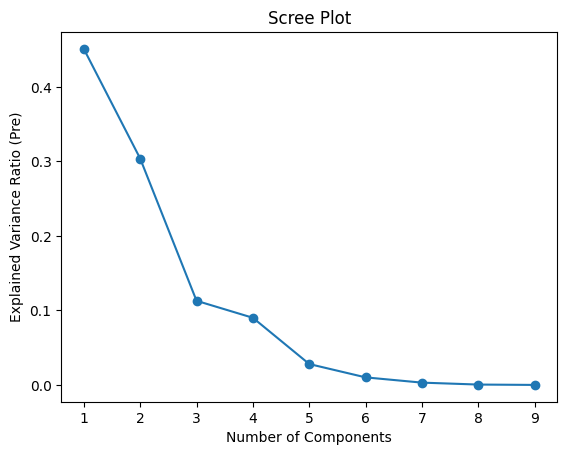

In [148]:
plt.plot(np.arange(1, len(pca_pre.explained_variance_ratio_) + 1), pca_pre.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio (Pre)')
plt.title('Scree Plot')
plt.show()

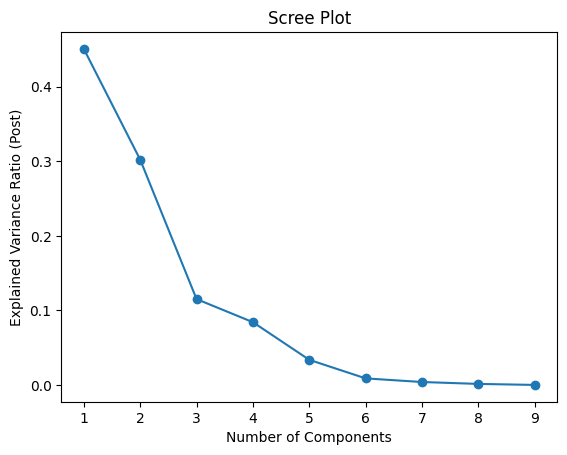

In [149]:
plt.plot(np.arange(1, len(pca_post.explained_variance_ratio_) + 1), pca_post.explained_variance_ratio_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio (Post)')
plt.title('Scree Plot')
plt.show()

In [150]:
pca_pre.components_

array([[ 4.11272779e-02,  6.19175465e-02,  4.90387662e-01,
         4.88189991e-01,  2.33955313e-01,  4.88651319e-01,
        -2.02014070e-02,  4.70894100e-01,  8.28903304e-04],
       [ 5.88488159e-01,  5.59577904e-01, -6.51002465e-02,
        -1.23889083e-02, -1.62935957e-01, -3.35485275e-02,
        -1.77320967e-01,  6.29013091e-02,  5.22579945e-01],
       [-2.29296486e-02,  1.68585442e-01, -2.12808449e-02,
        -9.93439820e-02,  4.96235081e-01, -9.70518986e-02,
         7.98222744e-01, -7.05838650e-03,  2.60486817e-01],
       [-1.71440770e-01, -3.06650535e-02, -3.11385028e-02,
        -1.26429617e-01,  7.34630936e-01, -1.09459672e-01,
        -5.70315372e-01, -9.38166352e-02,  2.58821261e-01],
       [-1.40138005e-01, -5.95516375e-01, -5.53968963e-04,
        -4.58503070e-02, -2.45798494e-01, -8.06544810e-03,
         4.21283339e-02,  2.69721844e-01,  6.99008161e-01],
       [-4.49978899e-02,  1.16009451e-01, -2.81403115e-01,
        -2.83525798e-01,  4.60850805e-02, -2.707572

In [155]:
pca_loadings_pre = pd.DataFrame(pca_pre.components_, columns = features, index=[f'PC{i+1}' for i in range(pca_pre.n_components_)])
pca_loadings_post = pd.DataFrame(pca_post.components_, columns = features, index=[f'PC{i+1}' for i in range(pca_post.n_components_)])
pca_loadings_post

,Median Household Income (dollars),Per Capita Income (dollars),Total Unemployed Population (over 16 years),Total Employed Population (over 16 years),Gini Index of Income Inequality,Total Population,Median Age,Total Foreign-born,Median Home Value (dollars)
PC1,0.055680,0.069328,0.491195,0.487130,0.219005,0.486607,-0.031154,0.476972,0.017377
PC2,0.587192,0.547014,-0.047571,-0.032378,-0.191859,-0.049801,-0.195456,0.041082,0.522963
PC3,0.005107,0.202183,-0.020116,-0.110688,0.526559,-0.106826,0.773023,0.012553,0.245035
PC4,-0.174357,0.080986,-0.035715,-0.119832,0.737554,-0.110725,-0.599886,-0.102382,0.144271
PC5,-0.162768,-0.603959,0.009612,-0.030434,-0.112396,-0.002447,-0.010933,0.153823,0.755845
PC6,0.017717,0.004199,-0.159650,-0.339326,-0.001150,-0.328066,-0.055595,0.846386,-0.178747
PC7,0.703146,-0.484691,0.344153,-0.124645,0.209523,-0.206422,0.004395,-0.117120,-0.190882
PC8,-0.314912,0.220959,0.779090,-0.274178,-0.193458,-0.347564,-0.012999,-0.077774,0.073542
PC9,-0.035882,-0.001053,-0.061497,0.726819,0.004174,-0.682654,0.000430,0.019349,0.015958


In [154]:
pca_loadings_pre.where(pca_loadings_pre > 0.3)
# pca_loadings_post.where(pca_loadings_post > 0.3)

,Median Household Income (dollars),Per Capita Income (dollars),Total Unemployed Population (over 16 years),Total Employed Population (over 16 years),Gini Index of Income Inequality,Total Population,Median Age,Total Foreign-born,Median Home Value (dollars)
PC1,NaN,NaN,0.490388,0.488190,NaN,0.488651,NaN,0.470894,NaN
PC2,0.588488,0.559578,NaN,NaN,NaN,NaN,NaN,NaN,0.522580
PC3,NaN,NaN,NaN,NaN,0.496235,NaN,0.798223,NaN,NaN
PC4,NaN,NaN,NaN,NaN,0.734631,NaN,NaN,NaN,NaN
PC5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.699008
PC6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.832163,NaN
PC7,0.763371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PC8,NaN,NaN,0.810294,NaN,NaN,NaN,NaN,NaN,NaN
PC9,NaN,NaN,NaN,0.710626,NaN,NaN,NaN,NaN,NaN


In [153]:
# pca_loadings_pre.where(pca_loadings_pre > 0.3)
pca_loadings_post.where(pca_loadings_post > 0.3)

,Median Household Income (dollars),Per Capita Income (dollars),Total Unemployed Population (over 16 years),Total Employed Population (over 16 years),Gini Index of Income Inequality,Total Population,Median Age,Total Foreign-born,Median Home Value (dollars)
PC1,NaN,NaN,0.491195,0.487130,NaN,0.486607,NaN,0.476972,NaN
PC2,0.587192,0.547014,NaN,NaN,NaN,NaN,NaN,NaN,0.522963
PC3,NaN,NaN,NaN,NaN,0.526559,NaN,0.773023,NaN,NaN
PC4,NaN,NaN,NaN,NaN,0.737554,NaN,NaN,NaN,NaN
PC5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.755845
PC6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.846386,NaN
PC7,0.703146,NaN,0.344153,NaN,NaN,NaN,NaN,NaN,NaN
PC8,NaN,NaN,0.779090,NaN,NaN,NaN,NaN,NaN,NaN
PC9,NaN,NaN,NaN,0.726819,NaN,NaN,NaN,NaN,NaN


In [158]:
features

['Median Household Income (dollars)',
 'Per Capita Income (dollars)',
 'Total Unemployed Population (over 16 years)',
 'Total Employed Population (over 16 years)',
 'Gini Index of Income Inequality',
 'Total Population',
 'Median Age',
 'Total Foreign-born',
 'Median Home Value (dollars)']

In [160]:
pca_loadings_pre

,Median Household Income (dollars),Per Capita Income (dollars),Total Unemployed Population (over 16 years),Total Employed Population (over 16 years),Gini Index of Income Inequality,Total Population,Median Age,Total Foreign-born,Median Home Value (dollars)
PC1,0.041127,0.061918,0.490388,0.488190,0.233955,0.488651,-0.020201,0.470894,0.000829
PC2,0.588488,0.559578,-0.065100,-0.012389,-0.162936,-0.033549,-0.177321,0.062901,0.522580
PC3,-0.022930,0.168585,-0.021281,-0.099344,0.496235,-0.097052,0.798223,-0.007058,0.260487
PC4,-0.171441,-0.030665,-0.031139,-0.126430,0.734631,-0.109460,-0.570315,-0.093817,0.258821
PC5,-0.140138,-0.595516,-0.000554,-0.045850,-0.245798,-0.008065,0.042128,0.269722,0.699008
PC6,-0.044998,0.116009,-0.281403,-0.283526,0.046085,-0.270757,-0.046356,0.832163,-0.234234
PC7,0.763371,-0.516835,0.133556,-0.098979,0.227985,-0.145972,0.034400,0.004884,-0.219134
PC8,-0.127117,0.135648,0.810294,-0.372006,-0.135156,-0.389073,-0.024773,0.004906,0.013906
PC9,-0.038915,-0.007783,-0.016066,0.710626,0.000038,-0.701879,-0.003044,0.012589,0.019408


In [1]:
PC_pre = {} 
idx=0
for PC_N, row in pca_loadings_pre.where(pca_loadings_pre > 0.3).iterrows():
    idx+=1
    # print(row)
    # print(len(row))
    row_features = []
    for i in range(len(features)): 
        if row[i] is not None:
            row_features.append(features[i])
    PC_pre[f'PC{idx+1}'] = row_features
PC_pre

NameError: name 'pca_loadings_pre' is not defined

In [169]:
PC_post = {} 
idx=0
for PC_N, row in pca_loadings_post.where(pca_loadings_post > 0.3).iterrows():
    idx+=1
    # print(row)
    # print(len(row))
    row_features = []
    for i in range(len(features)): 
        if row[i] is not None:
            row_features.append(features[i])
    PC_post[f'PC{idx+1}'] = row_features
PC_post

/var/folders/yc/96hyk6s92717zp_s_6_59khw0000gn/T/ipykernel_1518/3344485311.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[i] is not None:


{'PC2': ['Median Household Income (dollars)',
  'Per Capita Income (dollars)',
  'Total Unemployed Population (over 16 years)',
  'Total Employed Population (over 16 years)',
  'Gini Index of Income Inequality',
  'Total Population',
  'Median Age',
  'Total Foreign-born',
  'Median Home Value (dollars)'],
 'PC3': ['Median Household Income (dollars)',
  'Per Capita Income (dollars)',
  'Total Unemployed Population (over 16 years)',
  'Total Employed Population (over 16 years)',
  'Gini Index of Income Inequality',
  'Total Population',
  'Median Age',
  'Total Foreign-born',
  'Median Home Value (dollars)'],
 'PC4': ['Median Household Income (dollars)',
  'Per Capita Income (dollars)',
  'Total Unemployed Population (over 16 years)',
  'Total Employed Population (over 16 years)',
  'Gini Index of Income Inequality',
  'Total Population',
  'Median Age',
  'Total Foreign-born',
  'Median Home Value (dollars)'],
 'PC5': ['Median Household Income (dollars)',
  'Per Capita Income (dollars)

In [39]:
pca_loadings_post

,Median Household Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars),Per Capita Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars),Employment Status for the Population 16 Years and Over,Employment Status for the Population 16 Years and Over,Gini Index of Income Inequality,Total Population,Median Age by Sex,Place of Birth by Nativity and Citizenship Status,Median Value (Dollars)
PC1,0.055680,0.069328,0.491195,0.487130,0.219005,0.486607,-0.031154,0.476972,0.017377
PC2,0.587192,0.547014,-0.047571,-0.032378,-0.191859,-0.049801,-0.195456,0.041082,0.522963
PC3,0.005107,0.202183,-0.020116,-0.110688,0.526559,-0.106826,0.773023,0.012553,0.245035
PC4,-0.174357,0.080986,-0.035715,-0.119832,0.737554,-0.110725,-0.599886,-0.102382,0.144271


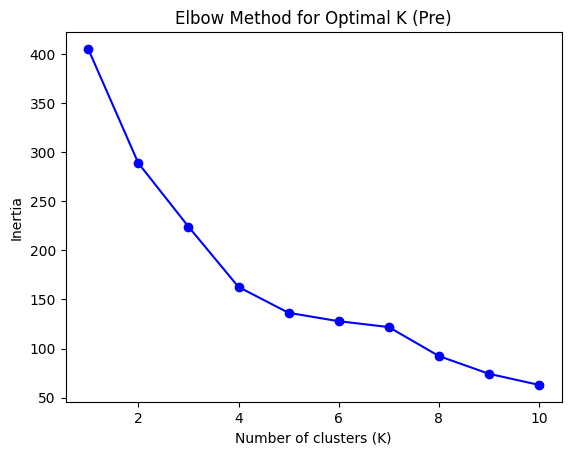

In [24]:
# Implement elbow method to determined best n_cluster for K-Means

from sklearn.cluster import KMeans

# Define range of K values
K = range(1, 11)

# Store inertia values for each K
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(acs_pre_grouped_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (Pre)')
plt.show()
# 4 looks good, let's do 4

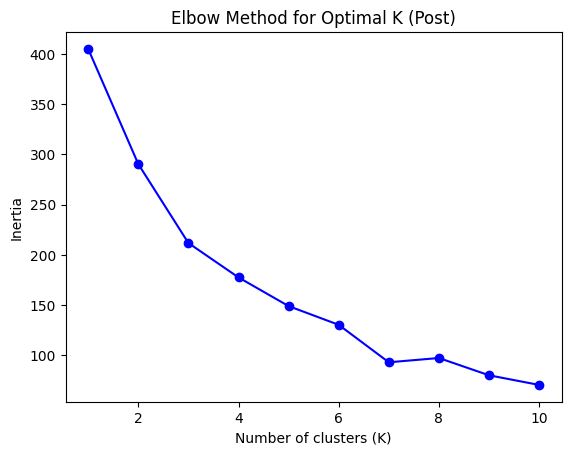

In [25]:
# Implement elbow method to determined best n_cluster for K-Means

from sklearn.cluster import KMeans

# Define range of K values
K = range(1, 11)

# Store inertia values for each K
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(acs_post_grouped_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (Post)')
plt.show()

In [26]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# Clusters prediction
kmeans_pre = kmeans.fit_predict(acs_pre_grouped_scaled)
kmeans_post = kmeans.fit_predict(acs_post_grouped_scaled)

acs_pre_grouped['kmeans_cluster'] = kmeans_pre #(take the non-scaled version bc this is a df, the scaled one isnt!)
acs_post_grouped['kmeans_cluster'] = kmeans_post